In [1]:
from product import Option, Strategy
from euronext import Page
from graph import Graph
g=Graph(4800, 5500, 25)


In [48]:
p = Page()
p.fetch()
options = p.scrap_options()
call = p.call
put = p.put
for k, o in p.call.items():
    o.multiplier=10
for k, o in p.put.items():
    o.multiplier=10


In [59]:
import requests
from bs4 import BeautifulSoup
class Page:
    def __init__(self, site=None, ticker_idx=0, params=None):
        self.tickers = ['4PX-DPAR', '2PX-DPAR', '1PX-DPAR', '5PX-DPAR']
        # liste des options euronext CAC40 :
        # https://derivatives.euronext.com/en/equity-index-derivatives/contract-list?quicktabs_309=4#quicktabs-309
        self.site = "https://derivatives.euronext.com/fr/products/index-options" if not site else site
        self.ticker = self.tickers[ticker_idx]
        self.params = "Class_type=0&Class_symbol=&Class_exchange=&ex=&ps=999&md=11-2018" if not params else params

    def fetch(self):
        requete = requests.get("{}/{}?{}".format(self.site, self.ticker, self.params))
        page = requete.content
        self.soup = BeautifulSoup(page, features="html.parser")
        self.page_title = self.soup.find("h1", {"class": "title"}).text
        self.call = {}
        self.put = {}
        return self.soup

    def scrap_options(self):
        div = self.soup.find("div", {"class": "call-put-table"})
        trs = div.find_all("tr")
        elmts = {}
        self.call = {}
        self.put = {}
        for tr in trs[3:-1]:
            tds = tr.find_all('td')
            print('{}'.format([td.text for td in tds]))
            if (str(tds[4].text) != '-' and 
                str(tds[5].text) != '-' and 
                str(tds[9].text) != '-' and
                str(tds[10].text) != '-') :
                strike = float(tds[7].text)
                achat = float(tds[4].text)
                vente = float(tds[5].text)
                c = Option('Call', strike=strike, achat=achat, vente=vente)
                achat = float(tds[9].text)
                vente = float(tds[10].text)
                p = Option('Put', strike=strike, achat=achat, vente=vente)
                elmts[float(c.strike)] = {'call': c, 'put': p}
                self.call[float(c.strike)] = c
                self.put[float(p.strike)] = p
        return elmts
    
p = Page()
p.fetch()
options = p.scrap_options()
p.call[4900].vente
call = p.call
put = p.put
for k, o in p.call.items():
    o.multiplier=10
for k, o in p.put.items():
    o.multiplier=10


['706.54', '-', '-', '-', '658.50', '668.50', 'C', '4400.00', 'P', '-', '1.20', '-', '-', '-', '0.43']
['507.55', '-', '-', '-', '460.30', '469.30', 'C', '4600.00', 'P', '1.40', '2.60', '-', '-', '-', '1.47']
['408.54', '-', '-', '-', '362.50', '370.50', 'C', '4700.00', 'P', '2.90', '4.40', '-', '-', '-', '2.47']
['310.86', '-', '-', '-', '266.60', '273.60', 'C', '4800.00', 'P', '6.10', '8.60', '6.10', '10', '-', '4.81']
['263.09', '-', '-', '-', '219.80', '226.80', 'C', '4850.00', 'P', '9.30', '11.80', '-', '-', '-', '7.05']
['216.27', '-', '-', '-', '175.30', '181.30', 'C', '4900.00', 'P', '14.10', '17.10', '16.90', '5', '-', '10.23']
['171.21', '-', '-', '-', '132.80', '138.80', 'C', '4950.00', 'P', '21.70', '24.70', '15.80', '20', '-', '15.18']
['128.63', '-', '-', '-', '94.40', '99.40', 'C', '5000.00', 'P', '32.30', '36.30', '36.50', '5', '-', '22.61']
['108.81', '-', '-', '-', '77.10', '82.10', 'C', '5025.00', 'P', '40.00', '44.00', '-', '-', '-', '27.80']
['89.93', '-', '-', '-'

In [61]:
call[4900].vente

181.3

In [ ]:
# test data when interet is fall
import numpy as np
sT = np.arange(4800,5400,25)
o = Option(strike=4900, achat=212.40, vente=219.40, multiplier=10)
c = Option(cat='Call', strike=4900, achat=212.40, vente=219.40, multiplier=10)
p = Option(cat='Put', strike=4900, achat=9.10, vente=11.60, multiplier=10)
print(str(o));print(str(c));print(str(p))

In [ ]:
s2 = Strategy('Strategy : call+2*put long').add(call[4900], 'long', 1).add(call[5300], 'short', 2)
g.profit(call[4950], 'long')
g.profit_strategy(s2)
g.compare(call[5000], 'long', s2, 'long')

Cost-Butterfly : 234.0
Cost-Call : 1034.0


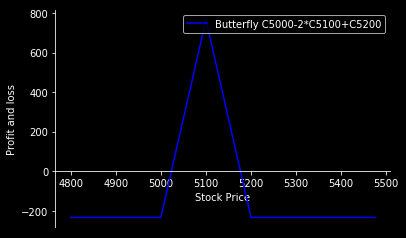

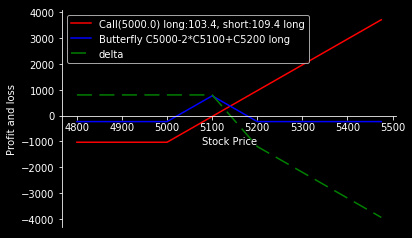

In [41]:
butterfly = (Strategy('Butterfly C5000-2*C5100+C5200')
             .add(call[5000], 'long', 1)
             .add(call[5100], 'short', 2)
             .add(call[5200], 'long', 1))
call_strike = 5000
print('Cost-Butterfly : {}'.format(butterfly.cost()))
print('Cost-Call : {}'.format(call[call_strike].cost('long')))
g.profit_strategy(butterfly)
g.compare(call[call_strike], 'long', butterfly, 'long')

Ratio Backspreads Cost : 988.0
Call 5000 Cost : 1048.0


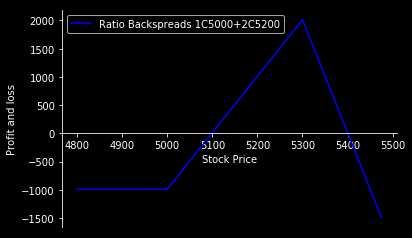

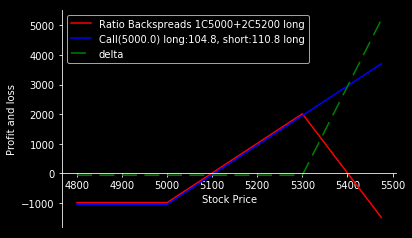

In [32]:
ratio_backspreads = (Strategy('Ratio Backspreads 1C5000+2C5200')
             .add(call[5000], 'long', 1)
             .add(call[5300], 'short', 3))
print('Ratio Backspreads Cost : {}'.format(ratio_backspreads.cost()))
print('Call 5000 Cost : {}'.format(call[5000].cost('long')))

g.profit_strategy(ratio_backspreads)
g.compare(ratio_backspreads, 'long', call[5000], 'long')

Straddle Cost : -4200.0


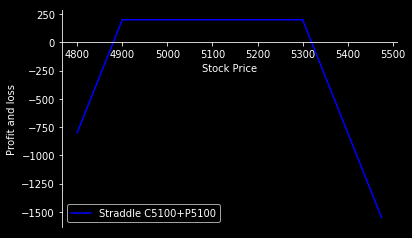

In [45]:
straddle = (Strategy('Straddle C5100+P5100')
             .add(call[4900], 'short', 1)
             .add(put[5300], 'short', 1))
print('Straddle Cost : {}'.format(straddle.cost()))
g.profit_strategy(straddle)

In [54]:
for s, c in call.items():
    print('{} {} {}'.format(c.strike, c.multiplier, c.vente))

4600.0 10 475.7
4700.0 10 376.7
4800.0 10 279.5
4850.0 10 232.7
4900.0 10 186.7
4950.0 10 143.8
5000.0 10 103.6
5025.0 10 85.5
5050.0 10 69.0
5075.0 10 55.0
5100.0 10 40.9
5125.0 10 30.1
5150.0 10 21.0
5175.0 10 14.7
5200.0 10 9.7
5250.0 10 4.0
5300.0 10 1.8


Stratis 5100-..-5300 croissant Cost : -3587.0
Stratis 5100-..-5300 decroissant Cost : -5641.0


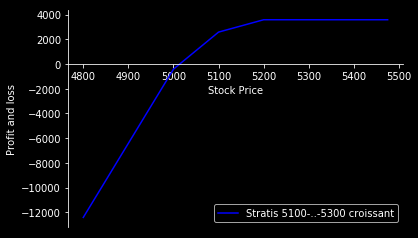

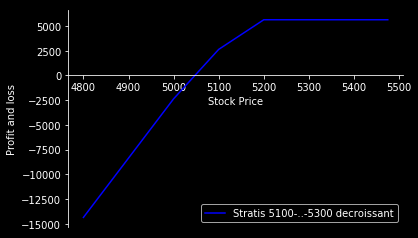

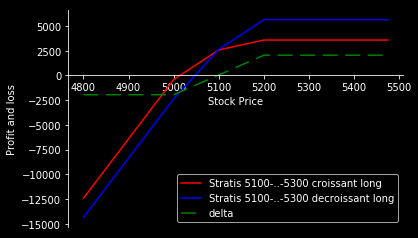

In [15]:
strat1 = (Strategy('Stratis 5100-..-5300 croissant')
             .add(put[5000], 'short', 3)
             .add(put[5100], 'short', 2)
             .add(put[5200], 'short', 1)
        )
strat2 = (Strategy('Stratis 5100-..-5300 decroissant')
             .add(put[5000], 'short', 1)
             .add(put[5100], 'short', 2)
             .add(put[5200], 'short', 3)
        )
print('{} Cost : {}'.format(strat1.label, strat1.cost()))
print('{} Cost : {}'.format(strat2.label, strat2.cost()))
g.profit_strategy(strat1)
g.profit_strategy(strat2)
g.compare(strat1, 'long', strat2, 'long')

In [ ]:
g.profit(call[5200], 'long')
print('cost: {}'.format(call[5200].cost('long')))
g.profit(call[5000], 'long')
print('cost: {}'.format(call[5000].cost('long')))


In [13]:
#ratio-spreads
from product import RatioSpread
rspread2 = RatioSpread(call[5200], call[5300])
print('{} Cost : {}'.format(rspread2.label, rspread2.cost()))
g.profit_strategy(rspread2)

ImportError: cannot import name 'RatioSpread'

Box Spread 5200.0-5000.0 Cost : 1908.0


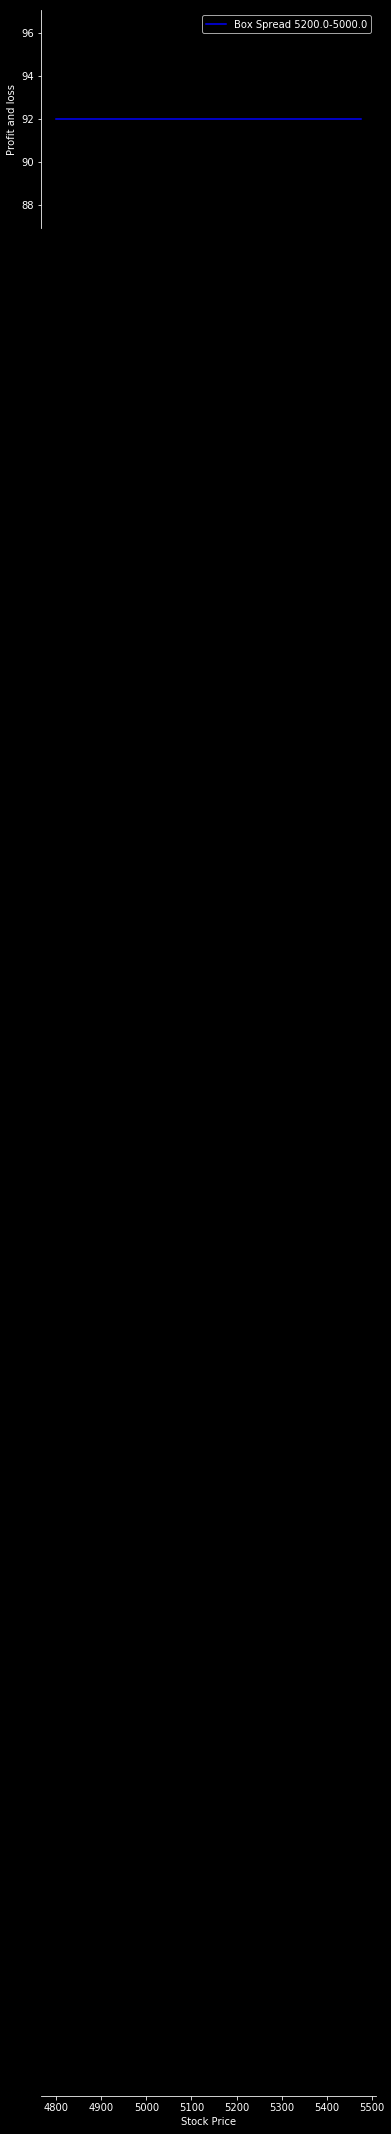

In [12]:
#????
#box-spreads pour John Hull
from math import ceil, floor
def BoxSpread(call_long, call_short, put_long, put_short):
    """A Box Spread is buy and sell put and call of different strike:
       - short a put at a strike
       - long a put at a strike inferior
       This a strategy of hedgin not speculatif
    """
    plong = call_long.achat
    pshort = call_short.vente
    plong = put_long.achat
    pshort = put_short.vente
    return (Strategy('Box Spread {}-{}'.format(put_long.strike, put_short.strike))
            .add(call_long, 'long', 1)
            .add(call_short, 'short', 1)
            .add(put_long, 'long', 1)
            .add(put_short, 'short', 1)
           )
bspread2 = BoxSpread(call[5000], call[5200], put[5200], put[5000])
print('{} Cost : {}'.format(bspread2.label, bspread2.cost()))
g.profit_strategy(bspread2)

Call Spread 4900.0-5000.0 Cost : 780.0


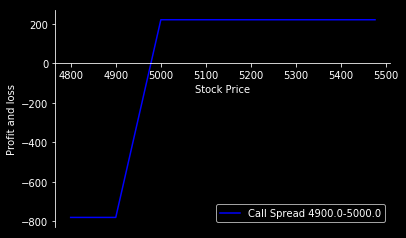

In [11]:
#call-spreads
#bull-spreads pour John Hull
from math import ceil, floor
def CallSpread(call_long, call_short):
    """A Call Spread is buy and sell call of different strike:
       - long a call at a strike
       - short a call at a strike superior
    """
    plong = call_long.achat
    pshort = call_short.vente
    return (Strategy('Call Spread {}-{}'.format(call_long.strike, call_short.strike))
            .add(call_long, 'long', 1)
            .add(call_short, 'short', 1)
           )
cspread2 = CallSpread(call[4900], call[5000])
print('{} Cost : {}'.format(cspread2.label, cspread2.cost()))
g.profit_strategy(cspread2)


Put Spread 5300.0-5000.0 Cost : 1880.0


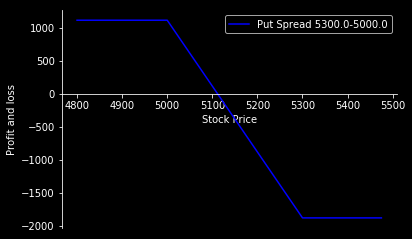

In [10]:
#put-spreads
#bear-spreads pour John Hull
from math import ceil, floor
def PutSpread(put_long, put_short):
    """A Put Spread is buy and sell put of different strike:
       - long a put at a strike
       - short a put at a strike inferior
    """
    plong = put_long.achat
    pshort = put_short.vente
    return (Strategy('Put Spread {}-{}'.format(put_long.strike, put_short.strike))
            .add(put_long, 'long', 1)
            .add(put_short, 'short', 1)
           )
pspread2 = PutSpread(put[5300], put[5000])
print('{} Cost : {}'.format(pspread2.label, pspread2.cost()))
g.profit_strategy(pspread2)


Iron Condor Cost : -220.0
Iron Condor Risk : -280.0


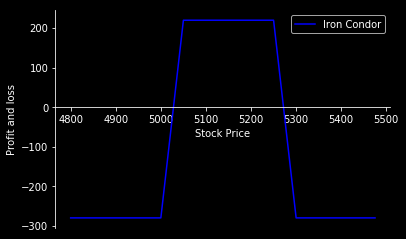

In [7]:
#Iron Condor
#??? pour John Hull
from math import ceil, floor
def IronCondor(put_k1, put_k2, call_k3, call_k4):
    """An Iron Condor is buy and sell put of different strike:
       - short put spread 90/80 permet d'encaisser 2.75
       - short call spread 110/120 permet d'encaisser 3.11
       That is equivalent to:
       - short a put at a strike (90)
       - long a put at a strike inferior (80)
       - short a call at a strike (110)
       - long a call at a strike superior (120)
       The spread strike must be the same
    """
    label = ('Iron Condor {}/{} - {}/{}'
             .format(put_k1.strike, put_k2.strike, call_k3.strike, call_k4.strike)
            )
    label = 'Iron Condor'
    return (Strategy(label)
            .add(put_k1, 'short', 1)
            .add(put_k2, 'long', 1)
            .add(call_k3, 'short', 1)
            .add(call_k4, 'long', 1)
           )
ironcondor = IronCondor(put[5050], put[4800], call[5250], call[5300])
print('{} Cost : {}'.format(ironcondor.label, ironcondor.cost()))
risk = min(ironcondor.payoff(g.sT, 'long'))
print('{} Risk : {}'.format(ironcondor.label,risk))
g.profit_strategy(ironcondor)